<a href="https://colab.research.google.com/github/shanizu/FUSE/blob/main/FUSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/shanizu/FUSE/blob/main/fuse.png?raw=true" width=300>


---


#**Fluorescent Cell Image Alignment and Analysis in Google Colab**
This Google Colab notebook provides an easy-to-use and accessible interface for the FUSE software, a powerful tool designed for aligning and analyzing fluorescent cells in time-series microscopy images. With seamless integration of Cellpose-generated segmentation masks, this notebook enables both novice and advanced users to effectively process and analyze their data in a cloud-based environment.


## SET UP
#### *Required for both segmentation and/or labeling*.

In [1]:
#@title 1. Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Supress default INFO logging
%%capture
!pip install fuse-toolkit --upgrade

#@title 2. Imports and functions{ display-mode: "form" }
#@markdown If you are using Cellpose for your analysis, it is highly recommended to change runtype to "GPU". CPU-based segmentation will be 10x slower.

# System
import ast

# Data structure
import pandas as pd
import numpy as np

# Image Processing
from ipywidgets import *
import ipywidgets as widgets
from PIL import Image, ImageOps

# Visualization
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import Markdown, display
from matplotlib.colors import ListedColormap
import seaborn as sns

# FUSE toolkit
import fuse_toolkit as fuse

In [3]:
#@title 3. Experiment information{ display-mode: "form" }
# Experiment information entry
date = "2024-02-01" #@param {type:"date"}
exp_ID = "FUSE_manual_comparison" #@param {type: "string"}
path = "/content/drive/Shareddrives/Berndt Lab Shared Drive/Project: FUSE/FUSE vs Manual Labeling/202308_FUSE_comparison/samples_02.tif" #@param {type:"string"}
parse_ID = "Name_Well" #@param {type:"string"}
separator = "_" #@param {type:"string"}
channel_info = "Fluor" #@param {type:"string"}
channel_to_seg = "Fluor" #@param {type:"string"}
num_frames = 90 #@param {type: "number"}-
frame_interval = 1 #@param {type: "number"}
frame_to_seg =  '0' #@param {type:"string"}
exp_note = "" #@param {type:"string"}
experiment = fuse.Experiment(date, exp_ID, path, parse_ID, separator,
                             channel_info, channel_to_seg, num_frames,
                             frame_interval, frame_to_seg, exp_note)

# Experiment information entry preprocessing
parse_ID = parse_ID.split(sep=separator)
channel_info = channel_info.split(sep=separator)
if len(channel_info) == 0:
  print("Please enter channel information.")
else:
  multichannel = True if len(channel_info) > 1 else False
if frame_to_seg != 'all':
  frame_to_seg = int(frame_to_seg)

# Create new directory, save information about the experiment
isDirectory = os.path.isdir(path)
if os.path.splitext(path)[-1].lower() == '.tif':
  folder = os.path.abspath(os.path.join(path, os.pardir))
elif isDirectory == True:
  folder = path

#Run Segmentation

100%|██████████| 25.3M/25.3M [00:01<00:00, 20.7MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 3.60MB/s]


/content/drive/Shareddrives/Berndt Lab Shared Drive/Project: FUSE/FUSE vs Manual Labeling/202308_FUSE_comparison/samples_02.tif


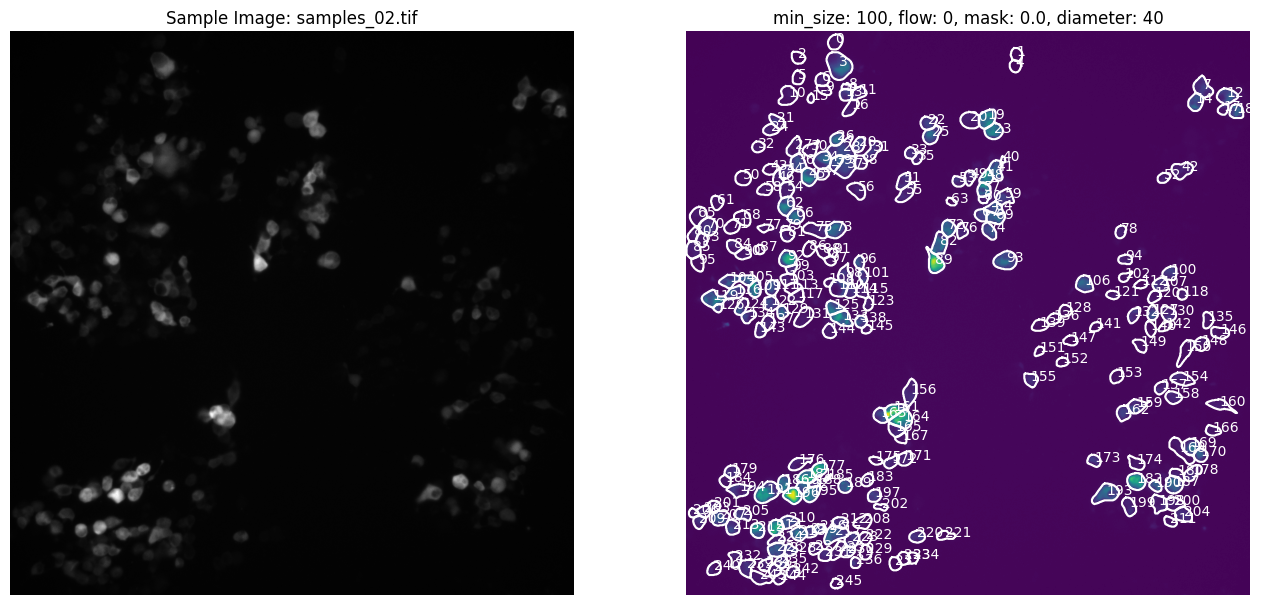

In [ ]:
#@title 1. Segmentation Information & Preview
#@markdown Read about Cellpose parameters [here](https://cellpose.readthedocs.io/en/latest/api.html).
min_size = 100 #@param {type:"number"}
flow_threshold= 0 #@param {type:"number"}
mask_threshold= 0.0 #@param {type:"number"}
diameter =  40 # @param {type:"number"}

experiment.preview_segmentation(
  min_size=min_size,
  flow_threshold=flow_threshold,
  mask_threshold=mask_threshold,
  diameter=diameter
)

In [ ]:
#@title 2. Run segmentation and save

df = experiment.segment_cells(
  min_size=min_size,
  flow_threshold=flow_threshold,
  mask_threshold=mask_threshold,
  diameter=diameter,
)

files completed:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/fuse_toolkit/experiment.py:532: UserWarning: /content/drive/Shareddrives/Berndt Lab Shared Drive/Project: FUSE/FUSE vs Manual Labeling/202308_FUSE_comparison/2024-02-01_FUSE_manual_comparison/segmentations/samples_02_seg.tif is a low contrast image
  io.imsave(os.path.join(


# Run Labeling

In [9]:
#@title 1. Cell labeling information

#@markdown **Please provide the required input information.**

#@markdown Define a search radius:
search_radius = 20 #@param {type:"number"}
#@markdown Define the weight **IOU** should impact cell-matching score:
iou_weight = 0.6 #@param {type:"number"}
#@markdown Define the weight **visual similarity** should impact cell-matching score:
visual_weight = 0.4 #@param {type:"number"}
#@markdown Define if cells across frames must overlap to be considered matching:
must_overlap = True #@param {type:"boolean"}
#@markdown Define the minimum percentage of frames in which a cell must be found to be considered connected:
min_connectivity = 100 #@param {type:"number"}


#@markdown **After running this block, the file(s) for which you would like to label cells.**

# Check for experiment info
if 'folder' in locals():
  pass
else:
  raise RuntimeError("Experiment information not found, please complete and run required code blocks.")

# Generate dropdown widget
image_folder = folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
image_files.sort()
image_files.insert(0, 'ALL')

dropdown = widgets.Dropdown(options=image_files)
display(dropdown)

selected = image_files[0]

def update_image(change):
  global selected
  selected = dropdown.value

dropdown.observe(update_image, names='value')

Dropdown(options=('ALL', 'samples_02.tif'), value='ALL')

In [10]:
#@title 2. Run cell labeling

#@markdown Run this block to label the cells in the selected files.

#@markdown **WARNING:** This will not save your results, run [step 4](https://colab.research.google.com/drive/1tWao_YhDedtCHlW5xAKkKKIeMxwhaQId#scrollTo=8nH3oMFBn6JQ&line=2&uniqifier=1) to save.

experiment.label_cells(
  to_label=selected,
  iou_weight=iou_weight,
  visual_weight=visual_weight,
  search_radius=search_radius,
  min_connectivity=min_connectivity,
  must_overlap=must_overlap,
  export_df=False
)
labeled_df = experiment.df

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

Labeling samples_02.tif


### 3. Preview labeling across frames

In [11]:
#@markdown ####Select a file
#@markdown Run this block and select the file for which you would like to preview the labels.
# Check for experiment info
if 'folder' in locals():
  pass
else:
  raise RuntimeError("Experiment information not found, please complete and run required code blocks.")

# Generate dropdown widget
image_folder = folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
image_files.sort()

dropdown = widgets.Dropdown(options=image_files)
display(dropdown)

selected_preview = image_files[0]

def update_image(change):
  global selected_preview
  selected_preview = dropdown.value

dropdown.observe(update_image, names='value')


Dropdown(options=('samples_02.tif',), value='samples_02.tif')

In [28]:
#@markdown ####Show results
#@markdown Note: When you change which frame you are viewing, it may take a few moments to load.

# Function Definition
def show_frames(frame_idx1: int, frame_idx2: int) -> None:
    """
    Displays two frames with labeled cell regions overlayed on the original images.

    Args:
        frame_idx1 (int): The index of the first frame to display.
        frame_idx2 (int): The index of the second frame to display.

    Returns:
        None
    """
    frame_indices = [frame_idx1, frame_idx2]

    _, axes = plt.subplots(1, 2, figsize=(16, 8))

    for idx, frame_idx in enumerate(frame_indices):
        img = img_data[frame_idx]
        if frame_to_seg == 'all':
          mask = masks.seek(frame_idx)
        else:
          mask = masks[0]

        axes[idx].imshow(img, cmap='gray', alpha=1)

        frame_info = preview_df[preview_df['Frame'] == frame_idx]
        for _, row in frame_info.iterrows():
            if not np.isnan(row['Label']):
                label_color = label_colormap[row['Label']]
                custom_cmap = ListedColormap(
                    [np.array([0, 0, 0, 0]), label_color])

                axes[idx].imshow(
                    np.where(mask == (row['ROI']+1), mask, 0),
                    cmap=custom_cmap,
                    alpha=0.3
                    )
                axes[idx].text(
                    row['y'],
                    row['x'],
                    str(int(row['Label'])),
                    fontsize=9,
                    color='white',
                    bbox=dict(facecolor='black', alpha=0.2)
                    )
        axes[idx].axis('off')
        axes[idx].set_title(f'Frame {frame_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Filter data for relevant labels
preview_df = labeled_df[labeled_df['Channel'] == channel_to_seg]
img_parsables = selected_preview.split(".")[0].split(separator)
for i, component in enumerate(parse_ID):
  preview_df = preview_df[preview_df[component].astype(str) == img_parsables[i]]

# Check that the file is labeled
if not 'Label' in preview_df.columns:
  raise RuntimeError("The given file has not been labeled")
if preview_df['Label'].isna().all():
  raise RuntimeError("The given file has no successful labels")

x_values = []
y_values = []
for item in preview_df['Centroid']:
    x, y = ast.literal_eval(item)
    x_values.append(x)
    y_values.append(y)
preview_df['x'] = x_values
preview_df['y'] = y_values

# Select segmented channel
channel_idx = channel_info.index(channel_to_seg)
channel_list = [int(i == channel_idx) for i in range(len(channel_info))]

# Check that masks exists
preview_seg = selected_preview.split(".")[0] + "_seg.tif"
masks_path = os.path.join(experiment.exp_folder, "segmentations", preview_seg)
if os.path.exists(masks_path):
  masks = fuse.read_multiframe_tif(masks_path)
else:
  raise FileNotFoundError(f"{masks_path} not found")

# Check that img exists
imgs_path = os.path.join(image_folder, selected_preview)
if os.path.exists(imgs_path):
  pass
else:
  raise FileNotFoundError(f"{imgs_path} not found")

# Import imgs and masks
img = Image.open(imgs_path)
n_frames_total = img.n_frames
n_channels = len(channel_list)
img_list = []
for channel, is_selected in enumerate(channel_list):
  if is_selected:
    channel_frames = []
    for i in range(channel, n_frames_total, n_channels):
      img.seek(i)
      channel_frames.append(np.array(img))
    img_list.extend(np.array(channel_frames))
img_data = img_list

masks = Image.open(masks_path)
n_frames_total = masks.n_frames
mask_list = []
for i in range(n_frames_total):
  masks.seek(i)
  mask_list.append(np.array(masks))
masks = mask_list

# Generate colors for each label
label_colormap = {}
unique_labels = np.unique(preview_df['Label'])
colors = plt.cm.prism(np.linspace(0, 1, len(unique_labels)))
for idx, label in enumerate(unique_labels):
    label_colormap[label] = colors[idx]

# Generate preview widget
frame_slider1 = widgets.IntSlider(
    min=0,
    max=len(img_data) - 1,
    step=1,
    description='Left Frame:'
    )

frame_slider2 = widgets.IntSlider(
    min=0,
    max=len(img_data) - 1,
    step=1,
    description='Right Frame:'
    )

widgets.interact(
    show_frames,
    frame_idx1=frame_slider1,
    frame_idx2=frame_slider2
    );

interactive(children=(IntSlider(value=0, description='Left Frame:', max=89), IntSlider(value=0, description='R…

### 4. Save labeling results

In [12]:
#@markdown Run this block and to save labels to csv file as new column called `Label`.

#@markdown **WARNING: If you do not save, the results may be lost!**

experiment.export_df()

# Derive Signal

In [13]:
# @title 1. Select signal and preferences

#@markdown Select the type of signal you would like to derive.
signal_type = "ΔF/F0" # @param ["ΔF/F0", "ratiometric (multichannel only)"]
#@markdown After running this block, provide the relevant information below.

# Check that setup is complete
if 'folder' in locals():
  pass
else:
  raise RuntimeError("Experiment information not found, please complete and run required code blocks.")

# Signal-Specific Inputs
default_name = "new_signal"
channel_info = experiment.channel_info
user_inputs = {}
if signal_type == "\u0394F/F0":
  signal_type="deltaFoverF0"
  default_name="deltaFoverF0"
  num_frames = widgets.IntText(
    value=5,
    # description='# frames:'
    )
  display(
    Markdown(data='####Enter the number of frames to use for the baseline fluorescence:'),
    num_frames
    )
  user_inputs['n_frames'] = num_frames
elif signal_type == "ratiometric (multichannel only)":
  if not experiment.multichannel:
    raise ValueError("Your data must have multiple channels to derive a ratiometric signal.")
  signal_type="ratiometric"
  default_name=f"{channel_info[0]}/{channel_info[1]}"
  user_inputs['channel_1'] = 'channel'
  channel_1 = widgets.Dropdown(
    value=channel_info[0],
    options=channel_info,
    description='channel 1:'
    )
  channel_2 = widgets.Dropdown(
    value=channel_info[1],
    options=channel_info,
    description='channel 2:'
    )
  display(
    Markdown(data='####Select the two channels you would like to use for the ratio:'),
    channel_1,
    channel_2
    )
  user_inputs['channel_1'] = channel_1
  user_inputs['channel_2'] = channel_2

# Output Name
output_name = widgets.Text(
  value=default_name,
  placeholder=f"ex. {default_name}"
  )
display(
  Markdown(data='####Output signal name for dataframe/csv column (max 20 characters):'),
  output_name,
  Markdown(data='*Caution: existing column with same name will be overwritten.*')
  )

# Plot Appearance Preferences
plot_title = widgets.Text(
  value="",
  placeholder=f"ex. My Plot",
  description="Title:"
  )
color_by_input = widgets.Dropdown(
  index=0,
  options=['None', 'Channel'] + parse_ID if multichannel else ['None'] + parse_ID,
  description="Color by:"
  )
style_by_input = widgets.Dropdown(
  index=0,
  options=['None', 'Channel'] + parse_ID if multichannel else ['None'] + parse_ID,
  description="Style by:"
  )
fs_input = widgets.IntText(
  value=0,
  description='Sampling Rate (Hz):',
  flex_flow='column',
  align_items='stretch',
  style= {'description_width': 'initial'}
  )
display(
  Markdown(data='####Preferences for plot:'),
  Markdown(data='(These will not affect the signal output)'),
  plot_title,
  color_by_input,
  style_by_input,
  fs_input,
  Markdown(data="*Hint: To use 'frames' on the X-axis, set Sampling Rate to 0.*")
  )


####Enter the number of frames to use for the baseline fluorescence:

IntText(value=5)

####Output signal name for dataframe/csv column (max 20 characters):

Text(value='deltaFoverF0', placeholder='ex. deltaFoverF0')

*Caution: existing column with same name will be overwritten.*

####Preferences for plot:

(These will not affect the signal output)

Text(value='', description='Title:', placeholder='ex. My Plot')

Dropdown(description='Color by:', options=('None', 'Name', 'Well'), value='None')

Dropdown(description='Style by:', options=('None', 'Name', 'Well'), value='None')

IntText(value=0, description='Sampling Rate (Hz):', style=DescriptionStyle(description_width='initial'))

*Hint: To use 'frames' on the X-axis, set Sampling Rate to 0.*

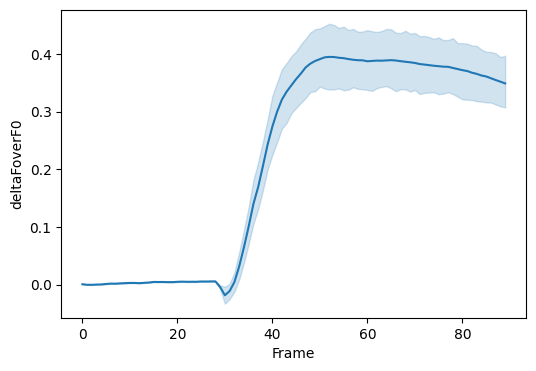

In [14]:
#@title 2. Preview results
#@markdown Running this block will derive and display the desired signal

# Prepare signal parameters
signal_params = {}
for parameter in user_inputs:
  signal_params[parameter] = user_inputs[parameter].value

# Derive signal
df = experiment.get_signal(
  signal_type, signal_params, output_name.value, export_df = False)

# Plot signal
color_set = None if color_by_input.value == 'None' else color_by_input.value
style_set = None if style_by_input.value == 'None' else style_by_input.value
if fs_input.value == 0:
  x_label, x_axis = 'Frame', df['Frame']
else:
  x_label, x_axis = 'Time (s)', df['Frame'] / fs_input.value

fig, ax = plt.subplots(figsize=(6,4))
ax = sns.lineplot(
  data=df,
  x=x_axis,
  y=output_name.value,
  hue=color_set,
  style=style_set
  ).set(title=plot_title.value, xlabel=x_label, ylabel=output_name.value)
plt.show()

In [ ]:
#@title 3. Save results
#@markdown Run this block and to save signal results to csv file as new column.

experiment.export_df()